In [20]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_dist.ipynb

# Hypothesis #1

Research Question:
If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [108]:
# project directory
project_dir = Path('/data/NNDSP')

# NNDSP data directories
nndsp_bids_dir = Path('/data/NNDSP/bids_2017_07_14_generic')
nndsp_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
nndsp_bar_dir = Path('/data/NNDSP/derivatives/bar_subj')
nndsp_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_bids_dir = Path('/data/HCP/HCP_900/s3/hcp')
hcp_fs_dir = Path('/data/NNDSP/derivatives/fs_hcp_subj')
hcp_bar_dir = Path('/data/NNDSP/derivatives/bar_hcp_subj')
hcp_pheno_file = Path('/data/NNDSP/nino/HCP_ages.csv')

# NKI data directories
nki_bids_dir = Path('/data/NNDSP/anal/NKI')
nki_fs_dir = Path('/data/NNDSP/derivatives/fs_nki_subj')
nki_bar_dir = Path('/data/NNDSP/derivatives/bar_nki_subj')
nki_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_bids_dir = Path('/data/DSST/CoRR/bids_corr')
corr_fs_dir = Path('/data/DSST/CoRR/fs_corr')
corr_bar_dir = Path('/data/DSST/CoRR/bar_corr/baracus')
corr_pheno_file = Path('/data/DSST/CoRR/phenotype_files/corr_ages.csv')

# SALD data directories
sald_bids_dir = Path('/data/DSST/SALD/bids_sald')
sald_fs_dir = Path('/data/DSST/SALD/fs_sald')
sald_bar_dir = Path('/data/DSST/SALD/bar_sald/baracus')
sald_pheno_file = Path('/data/DSST/SALD/phenotype_files/sub_information.xlsx')

## NNDSP Subject Data

In [4]:
# merge the subjects that we have fs and add subject number
df_nndsp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nndsp_fs_dir.glob('sub-*')]})
df_nndsp = df_nndsp.assign(MASKID = [int(Path(x).name[4:]) for x in df_nndsp.subj_paths])
df_nndsp.head()

,subj_paths,MASKID
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371


In [5]:
# merge the subjects we have fs of with their ages
df_nndsp = pd.merge(df_nndsp, pd.read_csv(nndsp_pheno_file.as_posix()), on='MASKID')

In [6]:
# rename columns so that we have standardization across datasets
df_nndsp = df_nndsp.rename(index=str, columns = {'MASKID' : 'subject', 'age_at_scan' : 'age'})
df_nndsp = df_nndsp.drop_duplicates(subset='subject', keep='first')
df_nndsp.head()

,subj_paths,subject,MRN,nuclear_fam_id,Sex,age
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889,7135075,10230,Female,9.667351
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011,7078997,10109,Male,18.310746
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948,4571265,1854,Female,14.269678
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198,4359628,1613,Male,14.390144
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371,7218874,10286,Male,16.621492


## HCP Subject Data

In [7]:
# merge the subjects that we have fs and add subject number
df_hcp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in hcp_fs_dir.glob('sub-*')]})
df_hcp = df_hcp.assign(Subject = [int(Path(x).name[4:]) for x in df_hcp.subj_paths])
df_hcp.head()

,subj_paths,Subject
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441


In [8]:
# merge the subjects we have fs of with their ages
df_hcp = pd.merge(df_hcp, pd.read_csv(hcp_pheno_file.as_posix()), on='Subject')

In [9]:
# rename columns so that we have standardization across datasets
df_hcp = df_hcp.rename(index=str, columns={'Subject' : 'subject', 'Age_in_Yrs' : 'age'})
df_hcp = df_hcp.drop_duplicates(subset='subject', keep='first')
df_hcp.head()

,subj_paths,subject,age,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361,29,True,NotTwin,,52442_82285,52442,82285,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942,27,True,NotTwin,,56029_85850,56029,85850,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773,28,True,NotTwin,,52801_82622,52801,82622,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959,26,True,NotMZ,,55795_85616,55795,85616,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441,28,True,NotTwin,,52875_82697,52875,82697,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


## NKI Subject Data

In [10]:
# merge the subjects that we have fs and add subject number
df_nki = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nki_fs_dir.glob('sub-*')]})
df_nki = df_nki.assign(participant_id = [Path(x).name[4:13] for x in df_nki.subj_paths])
df_nki.head()

,subj_paths,participant_id
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087
2,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236
3,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003


In [11]:
# merge the subjects that we have fs with age
df_nki = pd.merge(df_nki, pd.read_csv(nki_pheno_file.as_posix(), sep='\t'), on='participant_id')

In [12]:
# rename so that we have standardization across datasets
df_nki = df_nki.rename(index=str, columns={'participant_id' : 'subject', 'age' : 'age'})
df_nki = df_nki.drop_duplicates(subset='subject', keep='first')
df_nki.head()

,subj_paths,subject,age,sex,handedness
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510,23.0,MALE,RIGHT
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087,22.0,MALE,RIGHT
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236,33.0,MALE,RIGHT
7,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350,11.0,MALE,RIGHT
8,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003,13.0,MALE,RIGHT


## CoRR Subject Data

In [13]:
# merge the subjects that we have fs and add subject number
df_corr = pd.DataFrame({'subj_paths' : [x.as_posix() for x in corr_fs_dir.glob('sub-*')]})
df_corr = df_corr.assign(SUBID = [int(Path(x).name[4:11]) for x in df_corr.subj_paths])
df_corr.head()

,subj_paths,SUBID
0,/data/DSST/CoRR/fs_corr/sub-0025482,25482
1,/data/DSST/CoRR/fs_corr/sub-0027323_ses-3,27323
2,/data/DSST/CoRR/fs_corr/sub-0003057,3057
3,/data/DSST/CoRR/fs_corr/sub-0026120_ses-2,26120
4,/data/DSST/CoRR/fs_corr/sub-0025052,25052


In [14]:
# merge subjects with ages 
df_corr = pd.merge(df_corr, pd.read_csv(corr_pheno_file.as_posix()), on='SUBID')

In [15]:
# rename so that we have standardization across datasets
df_corr = df_corr.rename(index=str, columns={'SUBID' : 'subject', 'AGE_AT_SCAN_1' : 'age'})
df_corr = df_corr.sort_values(by='subj_paths')
df_corr = df_corr.drop_duplicates(subset='subject', keep='first')
df_corr.age = pd.to_numeric(df_corr.age, errors='coerce').fillna(0).astype(np.int64)
df_corr.head()

,subj_paths,subject,Unnamed: 0,age,SEX
1765,/data/DSST/CoRR/fs_corr/sub-0003001,3001,0,25,2
4018,/data/DSST/CoRR/fs_corr/sub-0003002,3002,2,23,1
4276,/data/DSST/CoRR/fs_corr/sub-0003004,3004,4,31,2
3942,/data/DSST/CoRR/fs_corr/sub-0003006,3006,6,23,1
131,/data/DSST/CoRR/fs_corr/sub-0003007,3007,8,43,2


## SALD Subject Data

In [16]:
# complete once we have SALD FS files
df_sald = pd.DataFrame({'subj_paths': [x.as_posix() for x in sald_fs_dir.glob('sub-*')]})
df_sald = df_sald.assign(Sub_ID = [int(Path(x).name[4:]) for x in df_sald.subj_paths])
df_sald.head()

,subj_paths,Sub_ID
0,/data/DSST/SALD/fs_sald/sub-031482,31482
1,/data/DSST/SALD/fs_sald/sub-031539,31539
2,/data/DSST/SALD/fs_sald/sub-031524,31524
3,/data/DSST/SALD/fs_sald/sub-031568,31568
4,/data/DSST/SALD/fs_sald/sub-031348,31348


In [17]:
# merge phenotype file with dataframe
df_sald = pd.merge(df_sald, pd.read_excel(sald_pheno_file.as_posix()), on='Sub_ID')

In [18]:
df_sald = df_sald.rename(index = str, columns = {'Sub_ID': 'subject', 'Age': 'age'})
df_sald = df_sald.sort_values(by='subject')
df_sald = df_sald.drop_duplicates(subset='subject', keep='first')
df_sald.age = pd.to_numeric(df_sald.age, errors='coerce').fillna(0).astype(np.int64)
df_sald.head()

,subj_paths,subject,Sex,age,Sex.1,Edinburgh Handedness Inventory (EHI),FunImg,T1Img
98,/data/DSST/SALD/fs_sald/sub-031274,31274,F,72,1,100.0,1,1
28,/data/DSST/SALD/fs_sald/sub-031277,31277,F,60,1,100.0,1,1
95,/data/DSST/SALD/fs_sald/sub-031279,31279,M,62,2,100.0,1,1
29,/data/DSST/SALD/fs_sald/sub-031281,31281,F,65,1,NaN,1,1
108,/data/DSST/SALD/fs_sald/sub-031285,31285,M,54,2,NaN,1,1


## Sample NKI:NNDSP

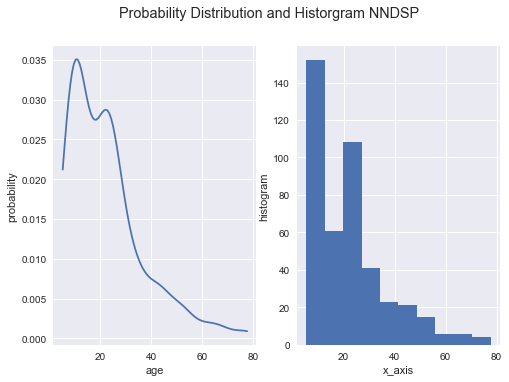

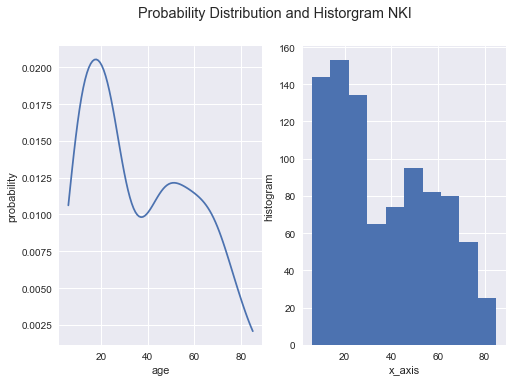

New Length:  329  with Precision:  1.0
Actual Length:  316


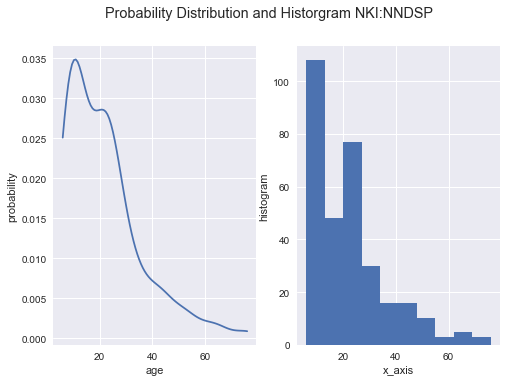

stats:  Ks_2sampResult(statistic=0.056462358427714854, pvalue=0.59053597735808294)


In [25]:
df_nki_nndsp = sample(df_nki, df_nndsp, title_to='NKI', title_from='NNDSP')

## Sample CoRR:NNDSP

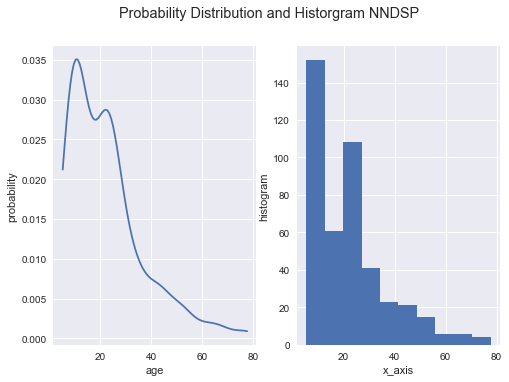

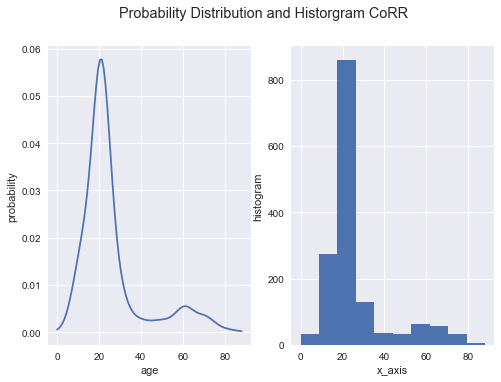

New Length:  187  with Precision:  1.0
Actual Length:  172


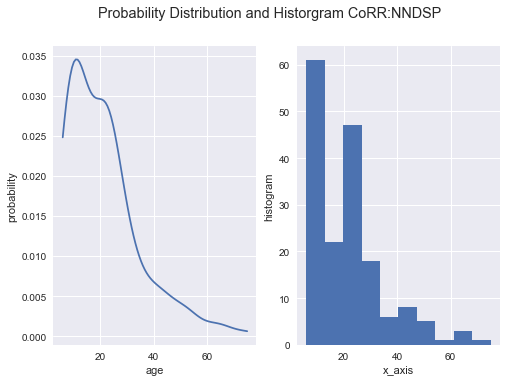

stats:  Ks_2sampResult(statistic=0.06823745410036719, pvalue=0.59871984735369399)


In [33]:
df_corr_nndsp = sample(df_corr, df_nndsp, title_to='CoRR', title_from='NNDSP', bucket_size=3)

## Sample SALD:NNDSP

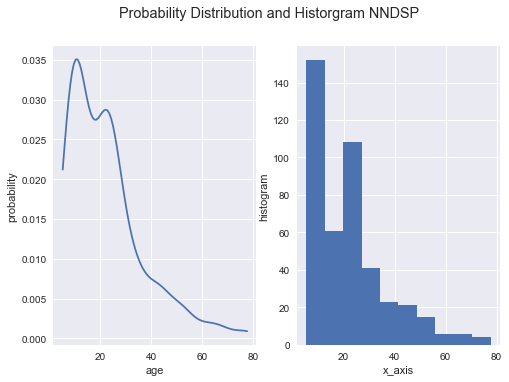

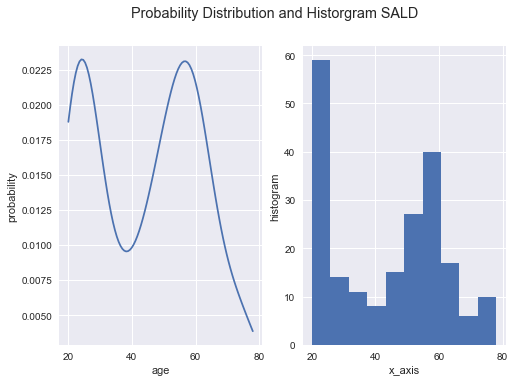

New Length:  128.27650835937249  with Precision:  0.1
Actual Length:  54


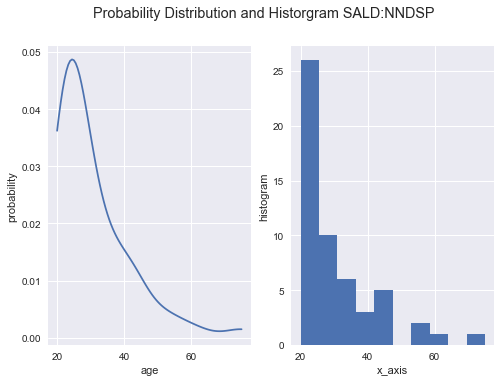

stats:  Ks_2sampResult(statistic=0.50050851767098903, pvalue=2.6886780740160029e-11)


In [45]:
df_sald_nndsp = sample(df_sald, df_nndsp, title_to='SALD', title_from='NNDSP', bucket_size=3)

## Sample NKI:HCP

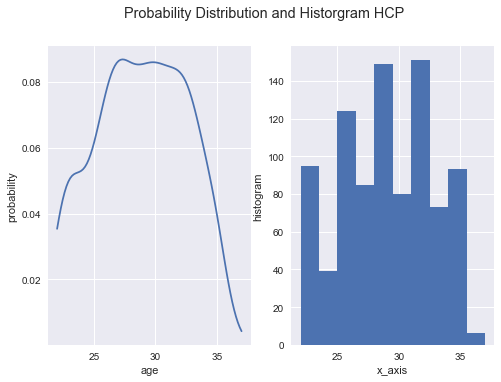

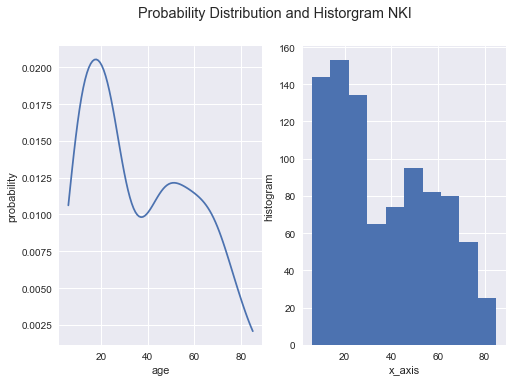

New Length:  94  with Precision:  1.0
Actual Length:  89


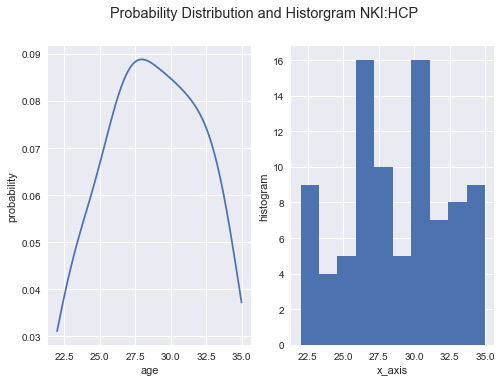

stats:  Ks_2sampResult(statistic=0.029577553198167073, pvalue=0.99999958360293306)


In [46]:
df_nki_hcp = sample(df_nki, df_hcp, title_to='NKI', title_from='HCP', bucket_size=2)

## Sample CoRR:HCP

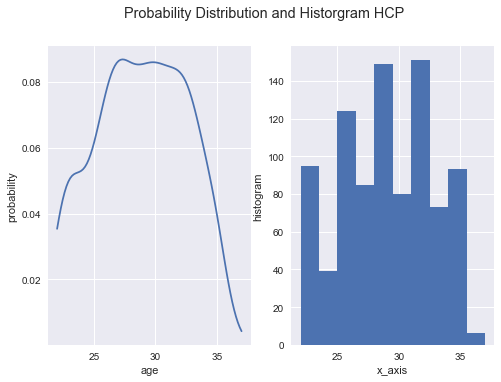

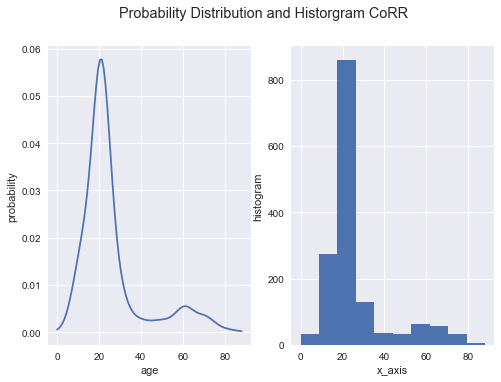

New Length:  102  with Precision:  1.0
Actual Length:  98


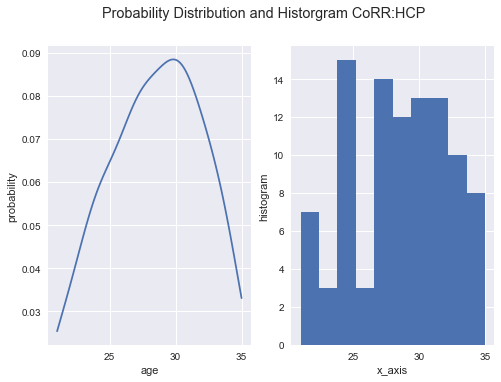

stats:  Ks_2sampResult(statistic=0.05483981302018015, pvalue=0.947606066355558)


In [49]:
df_corr_hcp = sample(df_corr, df_hcp, title_to='CoRR', title_from='HCP', bucket_size=3)

## Sample SALD:HCP

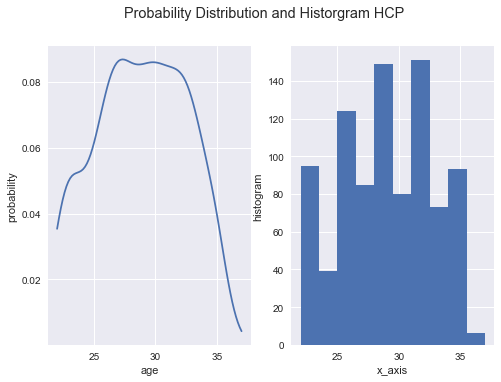

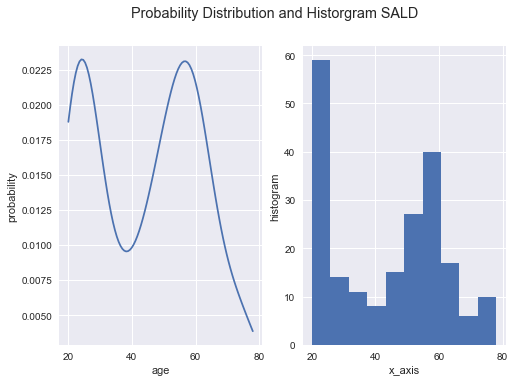

Actual Length:  35


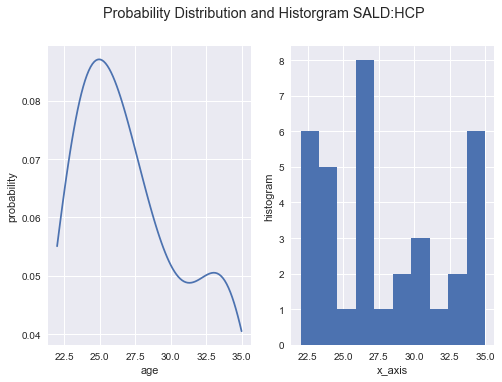

stats:  Ks_2sampResult(statistic=0.19744612928970473, pvalue=0.12737507186823213)


In [52]:
df_sald_hcp = sample(df_sald, df_hcp, title_to='SALD', title_from='HCP', bucket_size=2, new_len=65)

# Train Test Hypothesis

In [154]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

In [57]:
hcp_mae = {}
nki2hcp_mae = {}
corr2hcp_mae = {}
sald2hcp_mae = {}

## Train NNDSP

In [63]:
x, nndsp_features = subject_features([os.path.basename(s) for s in df_nndsp.subj_paths], nndsp_bar_dir)

In [68]:
scores_nndsp, nndsp_complex_train, nndsp_complex_test, nndsp_complex_pipes = complex_model(df_nndsp, nndsp_bar_dir, features = nndsp_features)


Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.0995618603829
Mean Absolute Error (Test, thickness): 6.51593350061

Subcortival Volumes Pipeline


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, aseg): 9.01093085836
Mean Absolute Error (Test, aseg): 11.7249547638

Cortical Surface Area Pipeline


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.0993071052439
Mean Absolute Error (Test, area): 12.7893701867

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 1
Mean Absolute Error (Train): 10.5569349164
Mean Absolute Error (Test): 11.4312309731
                     r2     rpear    rpear2        mae      medae
aseg          -0.180389  0.065738  0.004322  11.724955   8.698927
ct            -0.947333 -0.061486  0.003781  16.438576  14.338418
ca            -0.250076 -0.012647  0.000160  12.789370  10.551834
mean_pred     -0.180936 -0.028227  0.000797  12.276724   9.710476
pred_age_test -0.012260 -0.009555  0.000091  11.431231  10.581341


In [70]:
nndsp_simple_train, nndsp_simple_test, nndsp_simple_pipe = simple_model(df_nndsp, nndsp_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nndsp_complex_train, 
                                                                        model_test=nndsp_complex_test)

Finding Subjects
Extracting Features
     subject                                   subj_paths      MRN  \
53       102  /data/NNDSP/derivatives/fs5.3_subj/sub-0102  4569829   
115      114  /data/NNDSP/derivatives/fs5.3_subj/sub-0114  4578673   
327      126  /data/NNDSP/derivatives/fs5.3_subj/sub-0126  4572324   
289      127  /data/NNDSP/derivatives/fs5.3_subj/sub-0127  4572166   
138      133  /data/NNDSP/derivatives/fs5.3_subj/sub-0133  4601373   

     nuclear_fam_id     Sex        age  Intra_Cran_Vol   WM_Frac   GM_Frac  \
53            10392    Male  28.542094    1.581414e+06  0.325566  0.039989   
115           10391    Male  25.957563    1.607836e+06  0.334801  0.041092   
327           10381    Male   6.015058    1.373947e+06  0.295549  0.041849   
289           10381    Male   7.926078    1.497001e+06  0.289696  0.039456   
138           10208  Female  22.168378    1.435193e+06  0.302876  0.040307   

     CSF_Frac  
53   0.010659  
115  0.012042  
327  0.007700  
289  0.00

### Test on HCP

In [71]:
x, hcp_features = subject_features([os.path.basename(s) for s in df_hcp.subj_paths], hcp_bar_dir)

In [72]:
hcp_mae['Complex on NNDSP'] = complex_test(df_hcp, hcp_bar_dir, nndsp_complex_pipes, data='HCP', features=hcp_features)

Predicting from Pipelines
Mean Absolute Error (HCP thickness): 5.70207535058
Mean Absolute Error (HCP aseg): 10.0561536141
Mean Absolute Error (HCP area): 7.76407348483
Mean Absolute Error (HCP stack): 7.26980356591


In [73]:
hcp_mae['Simple on NNDSP'] = simple_test(df_hcp, hcp_bar_dir, nndsp_simple_pipe, data='HCP')

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (HCP simple): 7.91617437561


### Test on NKI:HCP

In [74]:
x, nki2hcp_features = subject_features([os.path.basename(s) for s in df_nki_hcp.subj_paths], nki_bar_dir)

In [76]:
nki2hcp_mae['Complex on NNDSP'] = complex_test(df_nki_hcp, nki_bar_dir, nndsp_complex_pipes, data='NKI:HCP', is_int=False, features=nki2hcp_features)

Predicting from Pipelines
Mean Absolute Error (NKI:HCP thickness): 7.11882019642
Mean Absolute Error (NKI:HCP aseg): 14.2605309594
Mean Absolute Error (NKI:HCP area): 8.60036009224
Mean Absolute Error (NKI:HCP stack): 7.31150408162


In [77]:
nki2hcp_mae['Simple on NNDSP'] = simple_test(df_nki_hcp, nki_bar_dir, nndsp_simple_pipe, data='NKI:HCP', is_int=False)

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (NKI:HCP simple): 8.79789405511


### Test on CORRS:HCP

In [142]:
df_corr_hcp.head()

,subj_paths,subject,Unnamed: 0,age,SEX
4246,/data/DSST/CoRR/fs_corr/sub-0026193,26193,6,23,2
3763,/data/DSST/CoRR/fs_corr/sub-0025697,25697,296,21,2
1646,/data/DSST/CoRR/fs_corr/sub-0025565,25565,36,22,2
3558,/data/DSST/CoRR/fs_corr/sub-0025662,25662,226,21,1
1792,/data/DSST/CoRR/fs_corr/sub-0025942,25942,42,21,1


In [128]:
x, corr2hcp_features = subject_features([os.path.basename(s) for s in df_corr_hcp.subj_paths], corr_bar_dir, 
                                        session='_ses-1')

sub-0027451 /data/DSST/CoRR/bar_corr/baracus/sub-0027451_ses-1/data/lh.thickness.mgh
sub-0027450 /data/DSST/CoRR/bar_corr/baracus/sub-0027450_ses-1/data/lh.thickness.mgh
sub-0027447 /data/DSST/CoRR/bar_corr/baracus/sub-0027447_ses-1/data/lh.thickness.mgh
sub-0027434 /data/DSST/CoRR/bar_corr/baracus/sub-0027434_ses-1/data/lh.thickness.mgh
sub-0027436 /data/DSST/CoRR/bar_corr/baracus/sub-0027436_ses-1/data/lh.thickness.mgh
sub-0027440 /data/DSST/CoRR/bar_corr/baracus/sub-0027440_ses-1/data/lh.thickness.mgh
sub-0026037_ses-1 /data/DSST/CoRR/bar_corr/baracus/sub-0026037_ses-1/data/lh.thickness.mgh
sub-0025051_ses-1 /data/DSST/CoRR/bar_corr/baracus/sub-0025051_ses-1/data/lh.thickness.mgh


In [146]:
corr2hcp_mae['Complex on NNDSP'] = complex_test(df_corr_hcp, corr_bar_dir, nndsp_complex_pipes, data='CoRR:HCP',
                                             features = corr2hcp_features, session = '_ses-1')

90
90
Predicting from Pipelines
Mean Absolute Error (CoRR:HCP thickness): 9.13715269968
Mean Absolute Error (CoRR:HCP aseg): 7.12176847254
Mean Absolute Error (CoRR:HCP area): 12.3696955062
Mean Absolute Error (CoRR:HCP stack): 6.71190494967


In [155]:
corr2hcp_mae['Simple on NNDSP'] = simple_test(df_corr_hcp, corr_bar_dir, nndsp_simple_pipe, 
                                              data='CoRR:HCP', session = '_ses-1')

Finding Subjects
90
90
Extracting Features
Predicting Pipes
Mean Absolute Error (CoRR:HCP simple): 8.80111222847


### Test on SALD:HCP

In [80]:
x, sald2hcp_features = subject_features([os.path.basename(s) for s in df_sald_hcp.subj_paths], sald_bar_dir)

In [81]:
sald2hcp_mae['Complex on NNDSP'] = complex_test(df_sald_hcp.drop_duplicates(), sald_bar_dir, nndsp_complex_pipes, data='SALD:HCP',
                                               features = sald2hcp_features)

Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 6.4733600134
Mean Absolute Error (SALD:HCP aseg): 9.47869264932
Mean Absolute Error (SALD:HCP area): 6.84139366034
Mean Absolute Error (SALD:HCP stack): 6.17810414802


In [83]:
sald2hcp_mae['Simple on NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, nndsp_simple_pipe, data='SALD:HCP')

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 7.77470885572


## Train NKI:NNDSP

In [84]:
x, nki2nndsp_features = subject_features([os.path.basename(s) for s in df_nki_nndsp.subj_paths], nki_bar_dir)

In [85]:
scores_nki2nndsp, nki2nndsp_complex_train, nki2nndsp_complex_test, nki2nndsp_complex_pipes = complex_model(df_nki_nndsp, 
                                                                                                           nki_bar_dir, 
                                                                                                           is_int = False,
                                                                                                          features=nki2nndsp_features)


Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.100032832348
Mean Absolute Error (Test, thickness): 7.02014271553

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 8.78686695146
Mean Absolute Error (Test, aseg): 12.9474223372

Cortical Surface Area Pipeline


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.0995649556782
Mean Absolute Error (Test, area): 12.7404641024

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 2
Mean Absolute Error (Train): 9.59812224264
Mean Absolute Error (Test): 11.3423912007
                     r2     rpear    rpear2        mae      medae
aseg          -0.279204 -0.027933  0.000780  12.947422  10.765101
ct            -0.791704 -0.117961  0.013915  15.958004  13.874682
ca            -0.194975 -0.005264  0.000028  12.740464  11.202699
mean_pred     -0.134614 -0.142298  0.020249  12.626446  10.399765
pred_age_test -0.035585  0.034100  0.001163  11.342391   9.349673


In [86]:
nki2nndsp_simple_train, nki2nndsp_simple_test, nki2nndsp_simple_pipe = simple_model(df_nki_nndsp, nki_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nki2nndsp_complex_train, 
                                                                        model_test=nki2nndsp_complex_test,
                                                                                   is_int=False)

Finding Subjects
Extracting Features
       subject                                         subj_paths   age  \
138  A00008399  /data/NNDSP/derivatives/fs_nki_subj/sub-A00008399  23.0   
76   A00018030  /data/NNDSP/derivatives/fs_nki_subj/sub-A00018030  11.0   
143  A00023510  /data/NNDSP/derivatives/fs_nki_subj/sub-A00023510  23.0   
40   A00027159  /data/NNDSP/derivatives/fs_nki_subj/sub-A00027159  11.0   
91   A00027167  /data/NNDSP/derivatives/fs_nki_subj/sub-A00027167  14.0   

        sex handedness  Intra_Cran_Vol   WM_Frac   GM_Frac  CSF_Frac  
138    MALE      RIGHT    1.758887e+06  0.309256  0.038880  0.008169  
76   FEMALE       LEFT    1.445121e+06  0.312098  0.041026  0.007810  
143    MALE      RIGHT    1.524289e+06  0.297085  0.041715  0.009721  
40     MALE      RIGHT    1.566265e+06  0.317734  0.040820  0.012409  
91   FEMALE      RIGHT    1.399602e+06  0.335369  0.044311  0.010648  
Training Model
Mean Absolute Error (Train): 10.3821633406
Mean Absolute Error (Test): 

### Test on HCP

In [87]:
hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_hcp, hcp_bar_dir, nki2nndsp_complex_pipes, data='HCP', is_int=True, features = hcp_features)

Predicting from Pipelines
Mean Absolute Error (HCP thickness): 8.57844876354
Mean Absolute Error (HCP aseg): 10.9580565974
Mean Absolute Error (HCP area): 8.00413557579
Mean Absolute Error (HCP stack): 7.58029880502


In [88]:
hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_hcp, hcp_bar_dir, nki2nndsp_simple_pipe, data='HCP')

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (HCP simple): 7.48953239083


### Test on CoRR:HCP

In [157]:
corr2hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_corr_hcp, corr_bar_dir, nki2nndsp_complex_pipes, data='CoRR:HCP',
        features = corr2hcp_features, session = '_ses-1')

90
90
Predicting from Pipelines
Mean Absolute Error (CoRR:HCP thickness): 6.11772212328
Mean Absolute Error (CoRR:HCP aseg): 9.86150255745
Mean Absolute Error (CoRR:HCP area): 7.10330994595
Mean Absolute Error (CoRR:HCP stack): 8.21014531404


In [158]:
corr2hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_corr_hcp, corr_bar_dir, nki2nndsp_simple_pipe, data='CoRR:HCP',
                                                 session = '_ses-1')

Finding Subjects
90
90
Extracting Features
Predicting Pipes
Mean Absolute Error (CoRR:HCP simple): 7.96345726091


### Test on SALD:HCP

In [89]:
sald2hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_sald_hcp, sald_bar_dir, nki2nndsp_complex_pipes, data='SALD:HCP',
                                                   features = sald2hcp_features)

Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 4.80079676694
Mean Absolute Error (SALD:HCP aseg): 8.35581718433
Mean Absolute Error (SALD:HCP area): 7.03414558276
Mean Absolute Error (SALD:HCP stack): 7.7712389931


In [90]:
sald2hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, nki2nndsp_simple_pipe, data='SALD:HCP')

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 6.67967080368


## Train on CoRR:NNDSP

In [160]:
scores_corr2nndsp, corr2nndsp_complex_train, corr2nndsp_complex_test, corr2nndsp_complex_pipes = complex_model(df_corr_nndsp, 
                                                                                                           corr_bar_dir, 
                                                                                                           is_int = True, 
                                                                                                            session = '_ses-1')

Finding Subjects
Extracting Features
sub-0026030_ses-1 /data/DSST/CoRR/bar_corr/baracus/sub-0026030_ses-1/data/lh.thickness.mgh
sub-0027223 /data/DSST/CoRR/bar_corr/baracus/sub-0027223_ses-1/data/lh.thickness.mgh
sub-0027449 /data/DSST/CoRR/bar_corr/baracus/sub-0027449_ses-1/data/lh.thickness.mgh
sub-0027448 /data/DSST/CoRR/bar_corr/baracus/sub-0027448_ses-1/data/lh.thickness.mgh
sub-0027441 /data/DSST/CoRR/bar_corr/baracus/sub-0027441_ses-1/data/lh.thickness.mgh
sub-0027451 /data/DSST/CoRR/bar_corr/baracus/sub-0027451_ses-1/data/lh.thickness.mgh
sub-0027440 /data/DSST/CoRR/bar_corr/baracus/sub-0027440_ses-1/data/lh.thickness.mgh

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.0999897210606
Mean Absolute Error (Test, thickness): 7.36296124479

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 5.5811087937
Mean Absolute Error (Test, aseg): 11.3720988682

Cortical Surface Area Pipeline


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.100028386918
Mean Absolute Error (Test, area): 12.1555995104

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 1
Mean Absolute Error (Train): 9.43842741224
Mean Absolute Error (Test): 10.7986924766
                     r2     rpear    rpear2        mae      medae
aseg          -0.326428  0.154374  0.023831  11.372099   7.298031
ct            -0.497667 -0.037278  0.001390  13.563471  10.237899
ca            -0.211143 -0.049693  0.002469  12.155600   9.922580
mean_pred     -0.089737  0.055757  0.003109  10.528183   7.407148
pred_age_test -0.004549  0.106187  0.011276  10.798692   9.196186


In [161]:
corr2nndsp_simple_train, corr2nndsp_simple_test, corr2nndsp_simple_pipe = simple_model(df_corr_nndsp, corr_bar_dir, 
                                                                        model=True, 
                                                                        model_train = corr2nndsp_complex_train, 
                                                                        model_test=corr2nndsp_complex_test,
                                                                                   is_int=True, session = '_ses-1')

Finding Subjects
Extracting Features
     subject                           subj_paths  Unnamed: 0  age SEX  \
148     3007  /data/DSST/CoRR/fs_corr/sub-0003007           8   43   2   
139     3012  /data/DSST/CoRR/fs_corr/sub-0003012          18   33   2   
143     3021  /data/DSST/CoRR/fs_corr/sub-0003021          34   37   1   
133     3044  /data/DSST/CoRR/fs_corr/sub-0003044          66   30   2   
149     3045  /data/DSST/CoRR/fs_corr/sub-0003045          68   42   1   

     Intra_Cran_Vol   WM_Frac   GM_Frac  CSF_Frac  
148    1.778628e+06  0.333185  0.037310  0.026221  
139    1.683250e+06  0.313064  0.038327  0.017934  
143    1.547091e+06  0.310999  0.035426  0.012719  
133    1.649441e+06  0.316516  0.039658  0.012732  
149    1.465742e+06  0.283742  0.037772  0.021354  
Training Model
Mean Absolute Error (Train): 9.04570740803
Mean Absolute Error (Test): 10.3388422962


### Test on HCP

In [163]:
hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_hcp, hcp_bar_dir, corr2nndsp_complex_pipes, data='HCP', is_int=True, 
                                               features = hcp_features)

895
895
Predicting from Pipelines
Mean Absolute Error (HCP thickness): 8.80369403293
Mean Absolute Error (HCP aseg): 9.88450501513
Mean Absolute Error (HCP area): 8.95571431459
Mean Absolute Error (HCP stack): 7.55149707791


In [164]:
hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_hcp, hcp_bar_dir, corr2nndsp_simple_pipe, data='HCP')

Finding Subjects
895
895
Extracting Features
Predicting Pipes
Mean Absolute Error (HCP simple): 10.2251150477


### Test on NKI:HCP

In [165]:
nki2hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_nki_hcp, nki_bar_dir, corr2nndsp_complex_pipes, data='NKI:HCP', 
                                                    is_int=False, features = nki2hcp_features)

75
75
Predicting from Pipelines
Mean Absolute Error (NKI:HCP thickness): 5.77694119628
Mean Absolute Error (NKI:HCP aseg): 12.4491564715
Mean Absolute Error (NKI:HCP area): 7.46939696343
Mean Absolute Error (NKI:HCP stack): 6.22967140905


In [166]:
nki2hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_nki_hcp, nki_bar_dir, corr2nndsp_simple_pipe, data='NKI:HCP', is_int = False)

Finding Subjects
75
75
Extracting Features
Predicting Pipes
Mean Absolute Error (NKI:HCP simple): 7.26704534923


### Test on SALD:HCP

In [167]:
sald2hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_sald_hcp, sald_bar_dir, corr2nndsp_complex_pipes, 
                                                     data='SALD:HCP', is_int=True, features = sald2hcp_features)

35
35
Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 4.81258620831
Mean Absolute Error (SALD:HCP aseg): 9.83084638326
Mean Absolute Error (SALD:HCP area): 8.12652637974
Mean Absolute Error (SALD:HCP stack): 5.22165649098


In [168]:
sald2hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, corr2nndsp_simple_pipe, data='SALD:HCP', is_int = True)

Finding Subjects
35
35
Extracting Features
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 6.95560504113


# Statistical Tests

In [189]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_stats.ipynb

## Test on HCP

In [185]:
hcp_mae

{'Complex on CoRR:NNDSP': 7.5514970779129129,
 'Complex on NKI:NNDSP': 7.580298805024472,
 'Complex on NNDSP': 7.2698035659050939,
 'Simple on CoRR:NNDSP': 10.225115047678456,
 'Simple on NKI:NNDSP': 7.4895323908313962,
 'Simple on NNDSP': 7.9161743756054266}

In [181]:
hcp_rand_ages = random_ages(df_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


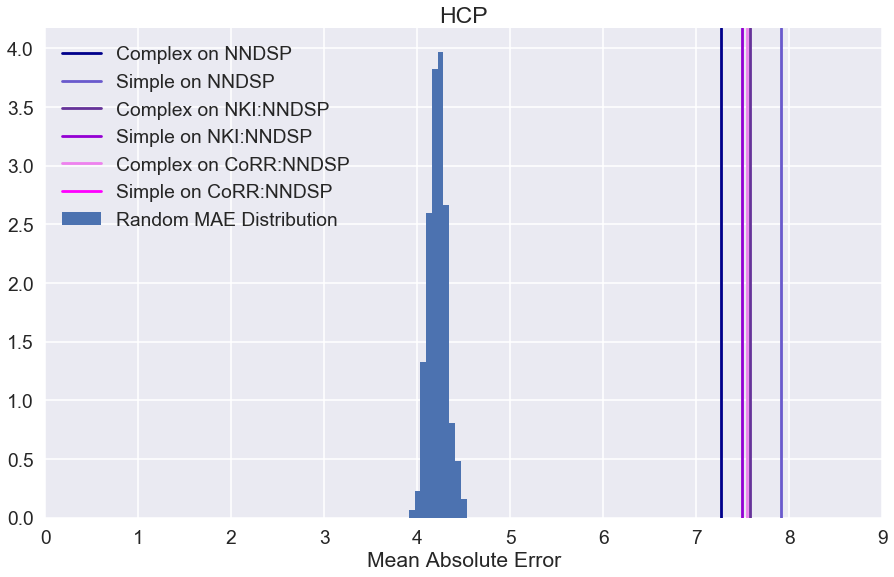

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on NKI:NNDSP 100.0
Percentile of  for Simple on NKI:NNDSP 100.0
Percentile of  for Complex on CoRR:NNDSP 100.0
Percentile of  for Simple on CoRR:NNDSP 100.0


In [206]:
plot_rand_hist(hcp_rand_ages, hcp_mae, title='HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 9), legend=True)
get_percentile(hcp_rand_ages, hcp_mae)

## Test NKI:HCP

In [ ]:
nki2hcp_rand_ages = random_ages(df_nki_hcp)

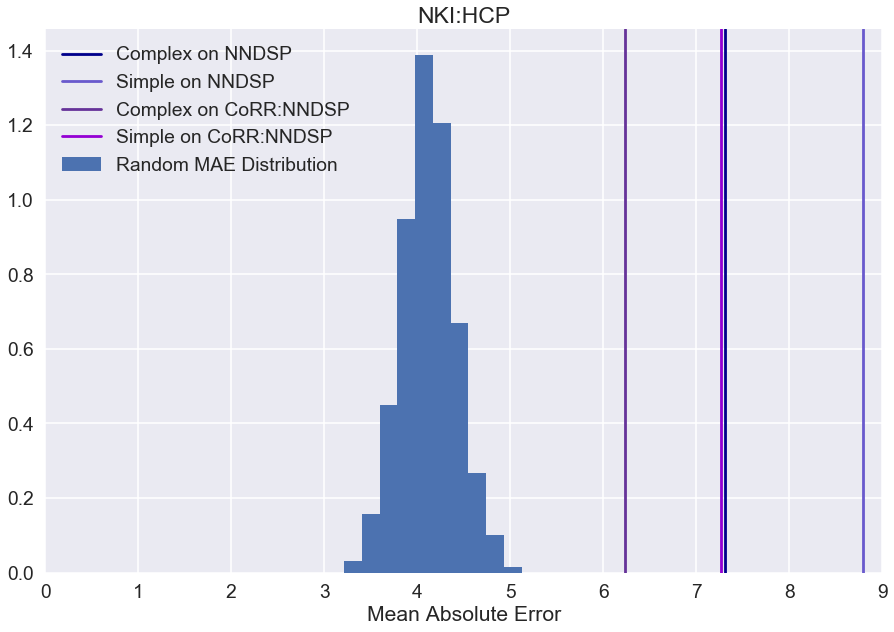

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on CoRR:NNDSP 100.0
Percentile of  for Simple on CoRR:NNDSP 100.0


In [208]:
plot_rand_hist(nki2hcp_rand_ages, nki2hcp_mae, title='NKI:HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(nki2hcp_rand_ages, nki2hcp_mae)

## Test CoRR:HCP

In [ ]:
corr2hcp_rand_ages = random_ages(df_corr_hcp)

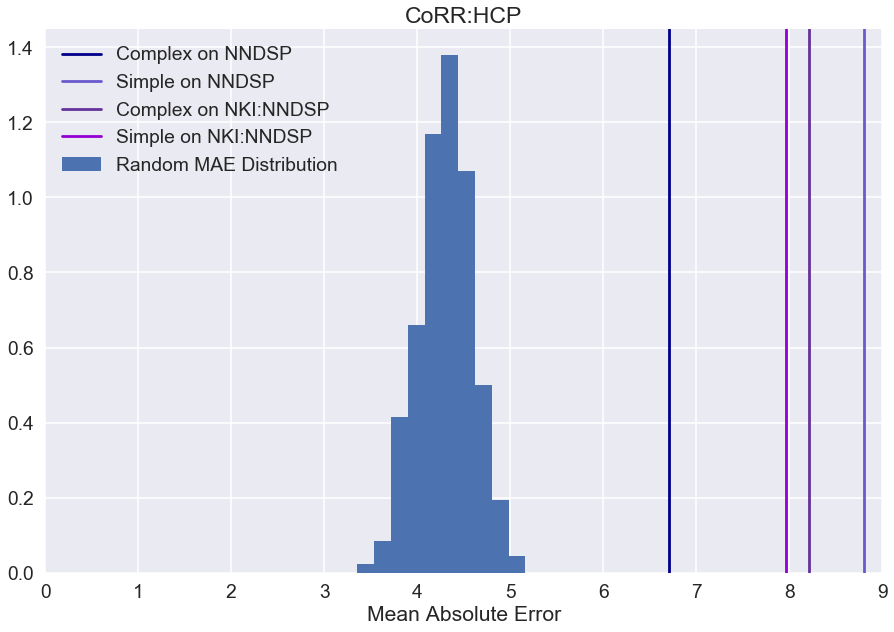

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on NKI:NNDSP 100.0
Percentile of  for Simple on NKI:NNDSP 100.0


In [209]:
plot_rand_hist(corr2hcp_rand_ages, corr2hcp_mae, title='CoRR:HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(corr2hcp_rand_ages, corr2hcp_mae)

## SALD:HCP

In [ ]:
sald2hcp_rand_ages = random_ages(df_sald_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


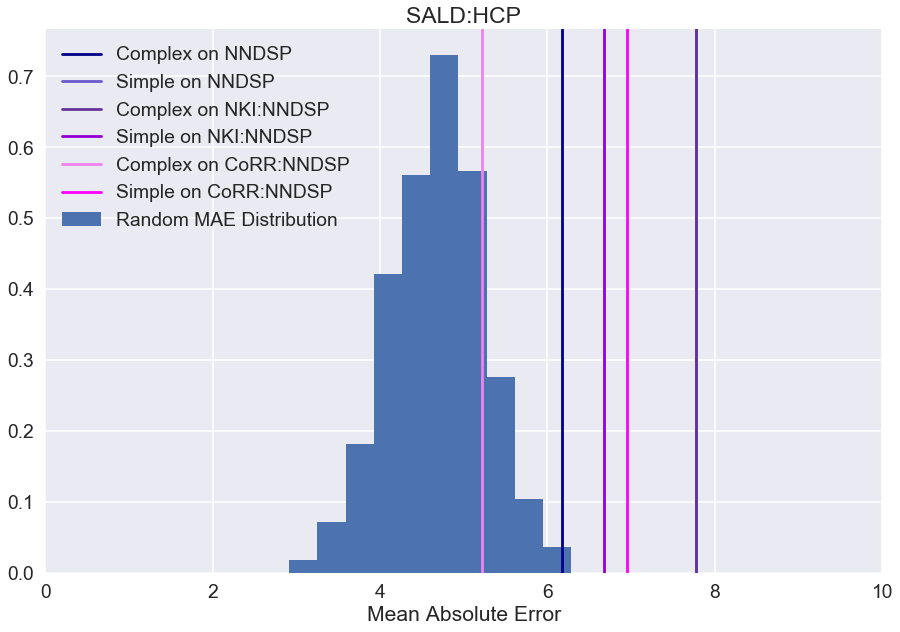

Percentile of  for Complex on NNDSP 99.8998998999
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on NKI:NNDSP 100.0
Percentile of  for Simple on NKI:NNDSP 100.0
Percentile of  for Complex on CoRR:NNDSP 82.5825825826
Percentile of  for Simple on CoRR:NNDSP 100.0


In [211]:
plot_rand_hist(sald2hcp_rand_ages, sald2hcp_mae, title='SALD:HCP', x_max=10,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(sald2hcp_rand_ages, sald2hcp_mae)